In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
!pip install biopython

    100% |████████████████████████████████| 2.2MB 1.6MB/s 


In [0]:
import pickle
import numpy as np
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import to_categorical
from random import shuffle
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools

In [0]:
# Define hyperparameters

BATCH_SIZE = 32
NUM_EPOCHS = 50
HIDDEN_UNITS = 64
LEARNING_RATE = 0.01
HIDDEN_LAYERS = 1
DROP_OUT = 0.3

In [0]:
# Define lists of amino acids including name, molecular weight, hydrophobicity, hydrophilicity. 

AA_NAMES = {'A': 'alanine',
            'B': 'aspartate/asparagine',
            'C': 'cystine',
            'D': 'aspartate',
            'E': 'glutamate',
            'F': 'phenylalanine',
            'G': 'glycine',
            'H': 'histidine',
            'I': 'isoleucine',
            'K': 'lysine',
            'L': 'leucine',
            'M': 'methionine',
            'N': 'asparagine',
            'P': 'proline',
            'Q': 'glutamine',
            'R': 'arginine',
            'S': 'serine',
            'T': 'threonine',
            'U': 'selenocysteine',
            'V': 'valine',
            'W': 'tryptophan',
            'Y': 'tyrosine',
            'Z': 'glutamate/glutamine'}

AA_NAMES_LIST = list(AA_NAMES.keys())

AA_NAMES_LIST.append('X')
AA_NAMES_LIST.append('*')

AA_MOLECULAR_WEIGHTS = {'A': 89.1, 
                        'C': 121.2,
                        'D': 133.1,
                        'E': 147.1,
                        'F': 165.2,
                        'G': 75.1,
                        'H': 155.2,
                        'I': 131.2,
                        'K': 146.2,
                        'L': 131.2,
                        'M': 149.2,
                        'N': 132.1,
                        'P': 115.1,
                        'Q': 146.2,
                        'R': 174.2,
                        'S': 105.1,
                        'T': 119.1,
                        'V': 117.1,
                        'W': 204.2,
                        'Y': 181.2}

AA_MOLECULAR_WEIGHTS_MEAN = np.mean(list(AA_MOLECULAR_WEIGHTS.values()))
AA_MOLECULAR_WEIGHTS_STD = np.std(list(AA_MOLECULAR_WEIGHTS.values()))

AA_MOLECULAR_WEIGHTS.update({'U': 167.1, 
                             'B': (AA_MOLECULAR_WEIGHTS['D'] + AA_MOLECULAR_WEIGHTS['N']) / 2,
                             'Z': (AA_MOLECULAR_WEIGHTS['E'] + AA_MOLECULAR_WEIGHTS['Q']) / 2,
                             'X': AA_MOLECULAR_WEIGHTS_MEAN})

AA_MOLECULAR_WEIGHTS_NORM = {k: (v - AA_MOLECULAR_WEIGHTS_MEAN) / AA_MOLECULAR_WEIGHTS_STD for k, v in
                             AA_MOLECULAR_WEIGHTS.items()}

def seq_molecular_weight(proteins):
    return np.mean([AA_MOLECULAR_WEIGHTS[aa] for aa in proteins])

AA_HYDROPHOBICITY = {'A': 1.8,
                     'C': 2.5,
                     'D': -3.5,
                     'E': -3.5,
                     'F': 2.8,
                     'G': -0.4,
                     'H': -3.2,
                     'I': 4.5,
                     'K': -3.9,
                     'L': 3.8,
                     'M': 1.9,
                     'N': -3.5,
                     'P': -1.6,
                     'Q': -3.5,
                     'R': -4.5,
                     'S': -0.8,
                     'T': -0.7,
                     'V': 4.2,
                     'W': -0.9,
                     'Y': -1.3}

AA_HYDROPHOBICITY_MEAN = np.mean(list(AA_HYDROPHOBICITY.values()))
AA_HYDROPHOBICITY_STD = np.std(list(AA_HYDROPHOBICITY.values()))

AA_HYDROPHOBICITY.update({'U': AA_HYDROPHOBICITY['C'],
                          'B': (AA_HYDROPHOBICITY['D'] + AA_HYDROPHOBICITY['N']) / 2,
                          'Z': (AA_HYDROPHOBICITY['E'] + AA_HYDROPHOBICITY['Q']) / 2,
                          'X': AA_HYDROPHOBICITY_MEAN})

AA_HYDROPHOBICITY_NORM = {k: (v - AA_HYDROPHOBICITY_MEAN) / AA_HYDROPHOBICITY_STD for k, v in AA_HYDROPHOBICITY.items()}

def seq_hydrophobicity(proteins):
    return np.mean([AA_HYDROPHOBICITY[aa] for aa in proteins])

AA_HYDROPHILICITY = {'A': -0.5,
                     'C': -1.0,
                     'D': 3.0,
                     'E': 3.0,
                     'F': -2.5,
                     'G': 0.0,
                     'H': -0.5,
                     'I': -1.8,
                     'K': 3.0,
                     'L': -1.8,
                     'M': -1.3,
                     'N': 0.2,
                     'P': 0.0,
                     'Q': 0.2,
                     'R': 3.0,
                     'S': 0.3,
                     'T': -0.4,
                     'V': -1.5,
                     'W': -3.4,
                     'Y': -2.3}

AA_HYDROPHILICITY_MEAN = np.mean(list(AA_HYDROPHILICITY.values()))
AA_HYDROPHILICITY_STD = np.std(list(AA_HYDROPHILICITY.values()))

AA_HYDROPHILICITY.update({'U': AA_HYDROPHILICITY['C'],
                          'B': (AA_HYDROPHILICITY['D'] + AA_HYDROPHILICITY['N']) / 2,
                          'Z': (AA_HYDROPHILICITY['E'] + AA_HYDROPHILICITY['Q']) / 2,
                          'X': AA_HYDROPHILICITY_MEAN})

AA_HYDROPHILICITY_NORM = {k: (v - AA_HYDROPHILICITY_MEAN) / AA_HYDROPHILICITY_STD for k, v in AA_HYDROPHILICITY.items()}

def seq_hydrophilicity(proteins):
    return np.mean([AA_HYDROPHILICITY[aa] for aa in proteins])
  
CLASSES = ['cyto', 'secreted', 'mito', 'nucleus']

In [0]:
# Preprocess training dataset

files = ['/content/gdrive/My Drive/MSc ML/0082/cyto.fasta.txt', 
         '/content/gdrive/My Drive/MSc ML/0082/secreted.fasta.txt', 
         '/content/gdrive/My Drive/MSc ML/0082/mito.fasta.txt', 
         '/content/gdrive/My Drive/MSc ML/0082/nucleus.fasta.txt']
proteins = []
location = []
s = ''
for file in files:
    with open(file, 'rb') as f:
        lines = f.readlines()
    count = 0
    for l in lines:
        l = l.decode("utf-8")
        if l[0] == '>':
            if count > 0:
                proteins.append(s)
                location.append(files.index(file))
            s = ''
        else:
            s += l[:-1]
            if count == len(lines) - 1:
                proteins.append(s)
                location.append(files.index(file))
        count += 1
with open('/content/gdrive/My Drive/MSc ML/0082/train_proteins', 'wb') as f:
    pickle.dump(proteins, f)
with open('/content/gdrive/My Drive/MSc ML/0082/train_location', 'wb') as f:
    pickle.dump(location, f)


In [0]:
with open('/content/gdrive/My Drive/MSc ML/0082/train_proteins', 'rb') as f:
    proteins = pickle.load(f)
with open('/content/gdrive/My Drive/MSc ML/0082/train_location', 'rb') as f:
    location = pickle.load(f)

In [0]:
combined = list(zip(proteins, location))
shuffle(combined)
proteins, location = zip(*combined)

In [0]:
proteins_train = proteins[:int(len(proteins)*0.8)]
proteins_val = proteins[int(len(proteins)*0.8):]
location_train = location[:int(len(location)*0.8)]
location_val = location[int(len(location)*0.8):]
location_train = np.array(location_train)
location_val = np.array(location_val)

In [0]:
# Create features

def create_feature(proteins):
    SEQ_LENGTH = []
    GLO_COMP = []
    LOC_FIRST = []
    LOC_LAST = []
    ISO_P = []
    MOL_W = []
    SEQ_START = []
    SEQ_END = []
    AROM = []
    HYDROPHO = []
    HYDROPHI = []
    for i in range(len(proteins)):
        SEQ_LENGTH.append(len(proteins[i]))
        analysed_seq = ProteinAnalysis(proteins[i])
        GLO_COMP.append(analysed_seq.get_amino_acids_percent())
        if len(proteins[i]) > 50:
            analysed_seq1 = ProteinAnalysis(proteins[i][:50])
            LOC_FIRST.append(analysed_seq1.get_amino_acids_percent())
            analysed_seq2 = ProteinAnalysis(proteins[i][-50:])
            LOC_LAST.append(analysed_seq2.get_amino_acids_percent())
        else:
            LOC_FIRST.append(analysed_seq.get_amino_acids_percent())
            LOC_LAST.append(analysed_seq.get_amino_acids_percent())
        ISO_P.append(analysed_seq.isoelectric_point())
        MOL_W.append(seq_molecular_weight(proteins[i]))
        if len(proteins[i]) >= 100:
            SEQ_START.append(proteins[i][:100])
            SEQ_END.append(proteins[i][-100:])
        else:
            length_ = 100-len(proteins[i])
            app = "*"*length_
            SEQ_START.append(proteins[i] + app)
            SEQ_END.append(proteins[i] + app)
        AROM.append(analysed_seq.aromaticity())
        HYDROPHO.append(seq_hydrophobicity(proteins[i]))
        HYDROPHI.append(seq_hydrophilicity(proteins[i]))
    return SEQ_LENGTH, GLO_COMP, LOC_FIRST, LOC_LAST, ISO_P, MOL_W, SEQ_START, SEQ_END, AROM, HYDROPHO, HYDROPHI
    

In [0]:
SEQ_LENGTH, GLO_COMP, LOC_FIRST, LOC_LAST, ISO_P, MOL_W, SEQ_START, SEQ_END, AROM, HYDROPHO, HYDROPHI = create_feature(proteins_train)
SEQ_LENGTH_val, GLO_COMP_val, LOC_FIRST_val, LOC_LAST_val, ISO_P_val, MOL_W_val, SEQ_START_val, SEQ_END_val, AROM_val, HYDROPHO_val, HYDROPHI_val = create_feature(proteins_val)

In [13]:
print('Mean of sequence length is:', np.mean(np.array(SEQ_LENGTH + SEQ_LENGTH_val)))
print('Standard deviation of sequence length is:', np.std(np.array(SEQ_LENGTH + SEQ_LENGTH_val)))
print('Maximum of sequence length is:', np.max(np.array(SEQ_LENGTH + SEQ_LENGTH_val)))
print('Minimum of sequence length is:', np.min(np.array(SEQ_LENGTH + SEQ_LENGTH_val)))


Mean of sequence length is: 546.8504662762958
Standard deviation of sequence length is: 514.2935216109184
Maximum of sequence length is: 13100
Minimum of sequence length is: 11


In [0]:
location_binary = to_categorical(location_train)
location_val_binary = to_categorical(location_val)

In [0]:
SEQ_START_encoded = []
for i in range(len(SEQ_START)):
    encoded_SEQ_START = [{c: k for k, c in enumerate(AA_NAMES_LIST)}[j] for j in SEQ_START[i]]
    SEQ_START_encoded.append(encoded_SEQ_START)
SEQ_START_encoded = np.array([np.array(xi) for xi in SEQ_START_encoded])

SEQ_END_encoded = []
for i in range(len(SEQ_END)):
    encoded_SEQ_END = [{c: k for k, c in enumerate(AA_NAMES_LIST)}[j] for j in SEQ_END[i]]
    SEQ_END_encoded.append(encoded_SEQ_END)
SEQ_END_encoded = np.array([np.array(xi) for xi in SEQ_END_encoded])

SEQ_START_encoded_val = []
for i in range(len(SEQ_START_val)):
    encoded_SEQ_START_val = [{c: k for k, c in enumerate(AA_NAMES_LIST)}[j] for j in SEQ_START_val[i]]
    SEQ_START_encoded_val.append(encoded_SEQ_START_val)
SEQ_START_encoded_val = np.array([np.array(xi) for xi in SEQ_START_encoded_val])

SEQ_END_encoded_val = []
for i in range(len(SEQ_END_val)):
    encoded_SEQ_END_val = [{c: k for k, c in enumerate(AA_NAMES_LIST)}[j] for j in SEQ_END_val[i]]
    SEQ_END_encoded_val.append(encoded_SEQ_END_val)
SEQ_END_encoded_val = np.array([np.array(xi) for xi in SEQ_END_encoded_val])


In [0]:
# GRU on the first 100 amino acids

model1 = tf.keras.models.Sequential()
model1.add(tf.keras.layers.Embedding(25, 32))
model1.add(tf.keras.layers.GRU(HIDDEN_UNITS))
model1.add(tf.keras.layers.Dense(4))
model1.add(tf.keras.layers.Activation('softmax'))
model1.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=RMSprop())

model1.fit(x=SEQ_START_encoded, 
          y=location_binary, 
          batch_size=BATCH_SIZE, 
          epochs=NUM_EPOCHS, 
          validation_data=(SEQ_START_encoded_val, location_val_binary))
SEQ_START_prediction = model1.predict(x=SEQ_START_encoded, batch_size=BATCH_SIZE)
SEQ_START_prediction_val = model1.predict(x=SEQ_START_encoded_val, batch_size=BATCH_SIZE)
model1.save('/content/gdrive/My Drive/MSc ML/0082/Model_RNN_SEQ_START.h5')

Train on 7377 samples, validate on 1845 samples
Epoch 1/50
7377/7377 [==============================] - 46s 6ms/sample - loss: 1.2206 - acc: 0.4252 - val_loss: 1.2118 - val_acc: 0.4054
Epoch 2/50
7377/7377 [==============================] - 45s 6ms/sample - loss: 1.1714 - acc: 0.4425 - val_loss: 1.1644 - val_acc: 0.4396
Epoch 3/50
7377/7377 [==============================] - 43s 6ms/sample - loss: 1.0781 - acc: 0.4750 - val_loss: 1.0835 - val_acc: 0.4726
Epoch 4/50
7377/7377 [==============================] - 42s 6ms/sample - loss: 1.0283 - acc: 0.4873 - val_loss: 1.0030 - val_acc: 0.4797
Epoch 5/50
7377/7377 [==============================] - 44s 6ms/sample - loss: 1.0346 - acc: 0.4846 - val_loss: 0.9860 - val_acc: 0.5106
Epoch 6/50
7377/7377 [==============================] - 43s 6ms/sample - loss: 1.0251 - acc: 0.4908 - val_loss: 0.9380 - val_acc: 0.5507
Epoch 7/50
7377/7377 [==============================] - 44s 6ms/sample - loss: 0.9405 - acc: 0.5437 - val_loss: 0.9681 - val_acc: 

In [0]:
# GRU on the last 100 amino acids

model2 = tf.keras.models.Sequential()
model2.add(tf.keras.layers.Embedding(25, 32))
model2.add(tf.keras.layers.GRU(HIDDEN_UNITS))
model2.add(tf.keras.layers.Dense(4))
model2.add(tf.keras.layers.Activation('softmax'))
model2.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

model2.fit(x=SEQ_END_encoded, 
          y=location_binary, 
          batch_size=BATCH_SIZE, 
          epochs=NUM_EPOCHS, 
          validation_data=(SEQ_END_encoded_val, location_val_binary))
SEQ_END_prediction = model2.predict(x=SEQ_END_encoded, batch_size=BATCH_SIZE)
SEQ_END_prediction_val = model2.predict(x=SEQ_END_encoded_val, batch_size=BATCH_SIZE)
model2.save('/content/gdrive/My Drive/MSc ML/0082/Model_RNN_SEQ_END.h5')

Train on 7377 samples, validate on 1845 samples
Epoch 1/50
7377/7377 [==============================] - 47s 6ms/sample - loss: 1.2125 - acc: 0.4278 - val_loss: 1.1658 - val_acc: 0.4320
Epoch 2/50
7377/7377 [==============================] - 45s 6ms/sample - loss: 1.1601 - acc: 0.4420 - val_loss: 1.1637 - val_acc: 0.4276
Epoch 3/50
7377/7377 [==============================] - 45s 6ms/sample - loss: 1.1472 - acc: 0.4510 - val_loss: 1.1533 - val_acc: 0.4352
Epoch 4/50
7377/7377 [==============================] - 45s 6ms/sample - loss: 1.1343 - acc: 0.4578 - val_loss: 1.2280 - val_acc: 0.4255
Epoch 5/50
7377/7377 [==============================] - 45s 6ms/sample - loss: 1.1379 - acc: 0.4612 - val_loss: 1.1467 - val_acc: 0.4488
Epoch 6/50
7377/7377 [==============================] - 45s 6ms/sample - loss: 1.1217 - acc: 0.4708 - val_loss: 1.1272 - val_acc: 0.4726
Epoch 7/50
7377/7377 [==============================] - 45s 6ms/sample - loss: 1.1121 - acc: 0.4675 - val_loss: 1.1566 - val_acc: 

In [0]:
GLO_COMP_encoded = []
for i in range(len(GLO_COMP)):
    encoded_GLO_COMP = [GLO_COMP[i][j] for j in GLO_COMP[i]]
    GLO_COMP_encoded.append(encoded_GLO_COMP)
GLO_COMP_encoded = np.array([np.array(xi) for xi in GLO_COMP_encoded])
# GLO_COMP_encoded = np.reshape(GLO_COMP_encoded, [GLO_COMP_encoded.shape[0], GLO_COMP_encoded.shape[1], -1])


In [0]:
GLO_COMP_encoded_val = []
for i in range(len(GLO_COMP_val)):
    encoded_GLO_COMP_val = [GLO_COMP_val[i][j] for j in GLO_COMP_val[i]]
    GLO_COMP_encoded_val.append(encoded_GLO_COMP_val)
GLO_COMP_encoded_val = np.array([np.array(xi) for xi in GLO_COMP_encoded_val])
# GLO_COMP_encoded_val = np.reshape(GLO_COMP_encoded_val, [GLO_COMP_encoded_val.shape[0], GLO_COMP_encoded_val.shape[1], -1])


In [40]:
GLO_COMP_encoded.shape

(7377, 20)

In [60]:
# DNN on the global amino acids composition

model3 = tf.keras.models.Sequential()
model3.add(tf.keras.layers.Dense(512, activation='relu'))
model3.add(tf.keras.layers.Dropout(rate=DROP_OUT))
model3.add(tf.keras.layers.Dense(256, activation='relu'))
model3.add(tf.keras.layers.Dropout(rate=DROP_OUT))
model3.add(tf.keras.layers.Dense(128, activation='relu'))
model3.add(tf.keras.layers.Dropout(rate=DROP_OUT))
model3.add(tf.keras.layers.Dense(64, activation='relu'))
model3.add(tf.keras.layers.Dropout(rate=DROP_OUT))
model3.add(tf.keras.layers.Dense(4))
model3.add(tf.keras.layers.Activation('softmax'))
model3.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='Adam')
model3.fit(x=GLO_COMP_encoded, 
          y=location_binary, 
          batch_size=BATCH_SIZE, 
          epochs=NUM_EPOCHS, 
          validation_data=(GLO_COMP_encoded_val, location_val_binary))
GLO_COMP_prediction = model3.predict(x=GLO_COMP_encoded, batch_size=BATCH_SIZE)
GLO_COMP_prediction_val = model3.predict(x=GLO_COMP_encoded_val, batch_size=BATCH_SIZE)
model3.save('/content/gdrive/My Drive/MSc ML/0082/Model_NN_GLO_COMP.h5')

Train on 7377 samples, validate on 1845 samples
Epoch 1/50
7377/7377 [==============================] - 2s 302us/sample - loss: 1.2141 - acc: 0.4088 - val_loss: 1.0740 - val_acc: 0.4878
Epoch 2/50
7377/7377 [==============================] - 2s 219us/sample - loss: 1.0966 - acc: 0.4792 - val_loss: 1.0317 - val_acc: 0.5279
Epoch 3/50
7377/7377 [==============================] - 2s 222us/sample - loss: 1.0541 - acc: 0.5025 - val_loss: 0.9922 - val_acc: 0.5501
Epoch 4/50
7377/7377 [==============================] - 2s 223us/sample - loss: 1.0284 - acc: 0.5158 - val_loss: 0.9763 - val_acc: 0.5593
Epoch 5/50
7377/7377 [==============================] - 2s 220us/sample - loss: 1.0187 - acc: 0.5265 - val_loss: 1.0193 - val_acc: 0.5599
Epoch 6/50
7377/7377 [==============================] - 2s 218us/sample - loss: 0.9951 - acc: 0.5402 - val_loss: 0.9540 - val_acc: 0.5924
Epoch 7/50
7377/7377 [==============================] - 2s 222us/sample - loss: 0.9871 - acc: 0.5481 - val_loss: 0.9785 - va

In [0]:
LOC_FIRST_encoded = []
for i in range(len(LOC_FIRST)):
    encoded_LOC_FIRST = [LOC_FIRST[i][j] for j in LOC_FIRST[i]]
    LOC_FIRST_encoded.append(encoded_LOC_FIRST)
LOC_FIRST_encoded = np.array([np.array(xi) for xi in LOC_FIRST_encoded])

In [0]:
LOC_FIRST_encoded_val = []
for i in range(len(LOC_FIRST_val)):
    encoded_LOC_FIRST_val = [LOC_FIRST_val[i][j] for j in LOC_FIRST_val[i]]
    LOC_FIRST_encoded_val.append(encoded_LOC_FIRST_val)
LOC_FIRST_encoded_val = np.array([np.array(xi) for xi in LOC_FIRST_encoded_val])
# LOC_FIRST_encoded_val = np.reshape(LOC_FIRST_encoded_val, [LOC_FIRST_encoded_val.shape[0], LOC_FIRST_encoded_val.shape[1], -1])


In [63]:
# DNN on the first 50 local amino acids composition

model4 = tf.keras.models.Sequential()
model4.add(tf.keras.layers.Dense(512, activation='relu'))
model4.add(tf.keras.layers.Dropout(rate=DROP_OUT))
model4.add(tf.keras.layers.Dense(256, activation='relu'))
model4.add(tf.keras.layers.Dropout(rate=DROP_OUT))
model4.add(tf.keras.layers.Dense(128, activation='relu'))
model4.add(tf.keras.layers.Dropout(rate=DROP_OUT))
model4.add(tf.keras.layers.Dense(64, activation='relu'))
model4.add(tf.keras.layers.Dropout(rate=DROP_OUT))
model4.add(tf.keras.layers.Dense(4))
model4.add(tf.keras.layers.Activation('softmax'))
model4.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='Adam')
model4.fit(x=LOC_FIRST_encoded, 
          y=location_binary, 
          batch_size=BATCH_SIZE, 
          epochs=NUM_EPOCHS, 
          validation_data=(LOC_FIRST_encoded_val, location_val_binary))
LOC_FIRST_prediction = model4.predict(x=LOC_FIRST_encoded, batch_size=BATCH_SIZE)
LOC_FIRST_prediction_val = model4.predict(x=LOC_FIRST_encoded_val, batch_size=BATCH_SIZE)
model4.save('/content/gdrive/My Drive/MSc ML/0082/Model_NN_LOC_FIRST.h5')

Train on 7377 samples, validate on 1845 samples
Epoch 1/50
7377/7377 [==============================] - 2s 297us/sample - loss: 1.2044 - acc: 0.4092 - val_loss: 1.0922 - val_acc: 0.4802
Epoch 2/50
7377/7377 [==============================] - 2s 222us/sample - loss: 1.0736 - acc: 0.4929 - val_loss: 1.0315 - val_acc: 0.5247
Epoch 3/50
7377/7377 [==============================] - 2s 220us/sample - loss: 1.0484 - acc: 0.5090 - val_loss: 1.0209 - val_acc: 0.5247
Epoch 4/50
7377/7377 [==============================] - 2s 221us/sample - loss: 1.0284 - acc: 0.5196 - val_loss: 1.0087 - val_acc: 0.5192
Epoch 5/50
7377/7377 [==============================] - 2s 224us/sample - loss: 1.0145 - acc: 0.5311 - val_loss: 0.9978 - val_acc: 0.5285
Epoch 6/50
7377/7377 [==============================] - 2s 222us/sample - loss: 0.9956 - acc: 0.5363 - val_loss: 1.0201 - val_acc: 0.5480
Epoch 7/50
7377/7377 [==============================] - 2s 223us/sample - loss: 0.9949 - acc: 0.5384 - val_loss: 1.0029 - va

In [0]:
LOC_LAST_encoded = []
for i in range(len(LOC_LAST)):
    encoded_LOC_LAST = [LOC_LAST[i][j] for j in LOC_LAST[i]]
    LOC_LAST_encoded.append(encoded_LOC_LAST)
LOC_LAST_encoded = np.array([np.array(xi) for xi in LOC_LAST_encoded])

In [0]:
LOC_LAST_encoded_val = []
for i in range(len(LOC_LAST_val)):
    encoded_LOC_LAST_val = [LOC_LAST_val[i][j] for j in LOC_LAST_val[i]]
    LOC_LAST_encoded_val.append(encoded_LOC_LAST_val)
LOC_LAST_encoded_val = np.array([np.array(xi) for xi in LOC_LAST_encoded_val])
# LOC_LAST_encoded_val = np.reshape(LOC_LAST_encoded_val, [LOC_LAST_encoded_val.shape[0], LOC_LAST_encoded_val.shape[1], -1])


In [66]:
# DNN on the last 50 local amino acids composition

model5 = tf.keras.models.Sequential()
model5.add(tf.keras.layers.Dense(512, activation='relu'))
model5.add(tf.keras.layers.Dropout(rate=DROP_OUT))
model5.add(tf.keras.layers.Dense(256, activation='relu'))
model5.add(tf.keras.layers.Dropout(rate=DROP_OUT))
model5.add(tf.keras.layers.Dense(128, activation='relu'))
model5.add(tf.keras.layers.Dropout(rate=DROP_OUT))
model5.add(tf.keras.layers.Dense(64, activation='relu'))
model5.add(tf.keras.layers.Dropout(rate=DROP_OUT))
model5.add(tf.keras.layers.Dense(4))
model5.add(tf.keras.layers.Activation('softmax'))
model5.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='Adam')
model5.fit(x=LOC_LAST_encoded, 
          y=location_binary, 
          batch_size=BATCH_SIZE, 
          epochs=NUM_EPOCHS, 
          validation_data=(LOC_LAST_encoded_val, location_val_binary))
LOC_LAST_prediction = model5.predict(x=LOC_LAST_encoded, batch_size=BATCH_SIZE)
LOC_LAST_prediction_val = model5.predict(x=LOC_LAST_encoded_val, batch_size=BATCH_SIZE)
model5.save('/content/gdrive/My Drive/MSc ML/0082/Model_NN_LOC_LAST.h5')

Train on 7377 samples, validate on 1845 samples
Epoch 1/50
7377/7377 [==============================] - 2s 307us/sample - loss: 1.2691 - acc: 0.3853 - val_loss: 1.2038 - val_acc: 0.4011
Epoch 2/50
7377/7377 [==============================] - 2s 221us/sample - loss: 1.2117 - acc: 0.4098 - val_loss: 1.1767 - val_acc: 0.4499
Epoch 3/50
7377/7377 [==============================] - 2s 220us/sample - loss: 1.1966 - acc: 0.4224 - val_loss: 1.1685 - val_acc: 0.4477
Epoch 4/50
7377/7377 [==============================] - 2s 224us/sample - loss: 1.1813 - acc: 0.4346 - val_loss: 1.1709 - val_acc: 0.4515
Epoch 5/50
7377/7377 [==============================] - 2s 223us/sample - loss: 1.1775 - acc: 0.4387 - val_loss: 1.1391 - val_acc: 0.4558
Epoch 6/50
7377/7377 [==============================] - 2s 223us/sample - loss: 1.1630 - acc: 0.4374 - val_loss: 1.1377 - val_acc: 0.4656
Epoch 7/50
7377/7377 [==============================] - 2s 225us/sample - loss: 1.1587 - acc: 0.4460 - val_loss: 1.1403 - va

In [0]:
fetures = []
fetures.append(SEQ_LENGTH)
fetures.append(ISO_P)
fetures.append(MOL_W)
fetures.append(AROM)
fetures.append(HYDROPHO)
fetures.append(HYDROPHI)
fetures = np.array(fetures).T

In [0]:
fetures_val = []
fetures_val.append(SEQ_LENGTH_val)
fetures_val.append(ISO_P_val)
fetures_val.append(MOL_W_val)
fetures_val.append(AROM_val)
fetures_val.append(HYDROPHO_val)
fetures_val.append(HYDROPHI_val)
fetures_val = np.array(fetures_val).T
# fetures_val = np.reshape(fetures_val, [fetures_val.shape[0], fetures_val.shape[1], -1])


In [69]:
# DNN on other features

model6 = tf.keras.models.Sequential()
model6.add(tf.keras.layers.Dense(512, activation='relu'))
model6.add(tf.keras.layers.Dropout(rate=DROP_OUT))
model6.add(tf.keras.layers.Dense(256, activation='relu'))
model6.add(tf.keras.layers.Dropout(rate=DROP_OUT))
model6.add(tf.keras.layers.Dense(128, activation='relu'))
model6.add(tf.keras.layers.Dropout(rate=DROP_OUT))
model6.add(tf.keras.layers.Dense(64, activation='relu'))
model6.add(tf.keras.layers.Dropout(rate=DROP_OUT))
model6.add(tf.keras.layers.Dense(4))
model6.add(tf.keras.layers.Activation('softmax'))
model6.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='Adam')
model6.fit(x=fetures, 
          y=location_binary, 
          batch_size=BATCH_SIZE, 
          epochs=NUM_EPOCHS, 
          validation_data=(fetures_val, location_val_binary))
features_prediction = model6.predict(x=fetures, batch_size=BATCH_SIZE)
features_prediction_val = model6.predict(x=fetures_val, batch_size=BATCH_SIZE)
model6.save('/content/gdrive/My Drive/MSc ML/0082/Model_NN_features.h5')

Train on 7377 samples, validate on 1845 samples
Epoch 1/50
7377/7377 [==============================] - 2s 309us/sample - loss: 8.6169 - acc: 0.3848 - val_loss: 6.0919 - val_acc: 0.3957
Epoch 2/50
7377/7377 [==============================] - 2s 221us/sample - loss: 2.4200 - acc: 0.3687 - val_loss: 1.2875 - val_acc: 0.4260
Epoch 3/50
7377/7377 [==============================] - 2s 228us/sample - loss: 1.2887 - acc: 0.3904 - val_loss: 1.2232 - val_acc: 0.4347
Epoch 4/50
7377/7377 [==============================] - 2s 224us/sample - loss: 1.2521 - acc: 0.4155 - val_loss: 1.2391 - val_acc: 0.4336
Epoch 5/50
7377/7377 [==============================] - 2s 223us/sample - loss: 1.2466 - acc: 0.4205 - val_loss: 1.2001 - val_acc: 0.4358
Epoch 6/50
7377/7377 [==============================] - 2s 222us/sample - loss: 1.2362 - acc: 0.4136 - val_loss: 1.1898 - val_acc: 0.4369
Epoch 7/50
7377/7377 [==============================] - 2s 223us/sample - loss: 1.2304 - acc: 0.4107 - val_loss: 1.1962 - va

In [0]:
PREDICT = np.concatenate((SEQ_START_prediction, SEQ_END_prediction, GLO_COMP_prediction, LOC_FIRST_prediction, LOC_LAST_prediction, features_prediction), axis=1)
PREDICT_val = np.concatenate((SEQ_START_prediction_val, SEQ_END_prediction_val, GLO_COMP_prediction_val, LOC_FIRST_prediction_val, LOC_LAST_prediction_val, features_prediction_val), axis=1)


In [72]:
# Stacking DNN on previous output

model7 = tf.keras.models.Sequential()
model7.add(tf.keras.layers.Dense(512, activation='relu'))
model7.add(tf.keras.layers.Dropout(rate=0.5))
model7.add(tf.keras.layers.Dense(256, activation='relu'))
model7.add(tf.keras.layers.Dropout(rate=0.5))
model7.add(tf.keras.layers.Dense(128, activation='relu'))
model7.add(tf.keras.layers.Dropout(rate=0.5))
model7.add(tf.keras.layers.Dense(64, activation='relu'))
model7.add(tf.keras.layers.Dropout(rate=0.5))
model7.add(tf.keras.layers.Dense(4))
model7.add(tf.keras.layers.Activation('softmax'))
model7.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='Adam')
model7.fit(x=PREDICT, 
          y=location_binary, 
          batch_size=BATCH_SIZE, 
          epochs=NUM_EPOCHS, 
          validation_data=(PREDICT_val, location_val_binary))
model7.save('/content/gdrive/My Drive/MSc ML/0082/Model_NN.h5')

Train on 7377 samples, validate on 1845 samples
Epoch 1/50
7377/7377 [==============================] - 2s 321us/sample - loss: 0.6890 - acc: 0.7105 - val_loss: 0.5427 - val_acc: 0.7892
Epoch 2/50
7377/7377 [==============================] - 2s 223us/sample - loss: 0.5040 - acc: 0.8165 - val_loss: 0.5873 - val_acc: 0.7718
Epoch 3/50
7377/7377 [==============================] - 2s 221us/sample - loss: 0.4759 - acc: 0.8253 - val_loss: 0.5511 - val_acc: 0.7767
Epoch 4/50
7377/7377 [==============================] - 2s 223us/sample - loss: 0.4804 - acc: 0.8216 - val_loss: 0.5452 - val_acc: 0.7789
Epoch 5/50
7377/7377 [==============================] - 2s 224us/sample - loss: 0.4711 - acc: 0.8276 - val_loss: 0.5620 - val_acc: 0.7843
Epoch 6/50
7377/7377 [==============================] - 2s 222us/sample - loss: 0.4546 - acc: 0.8316 - val_loss: 0.5597 - val_acc: 0.7805
Epoch 7/50
7377/7377 [==============================] - 2s 224us/sample - loss: 0.4617 - acc: 0.8327 - val_loss: 0.5483 - va

In [0]:
PREDICT_prediction_val = model7.predict(x=PREDICT_val, batch_size=BATCH_SIZE)
PREDICT_prediction_val_ = np.argmax(PREDICT_prediction_val, axis=1)

In [0]:
# Confusion Matrix

Confusion_Matrix = confusion_matrix(location_val, PREDICT_prediction_val_)
Confusion_Matrix = Confusion_Matrix.astype('float') / Confusion_Matrix.sum(axis=1)[:, np.newaxis]

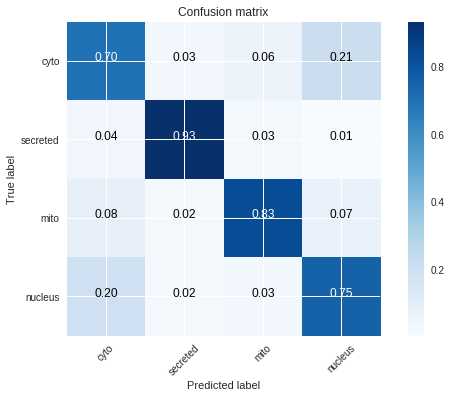

In [91]:
plt.figure()
plt.imshow(Confusion_Matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(4)
plt.xticks(tick_marks, CLASSES, rotation=45)
plt.yticks(tick_marks, CLASSES)

fmt = '.2f'
thresh = Confusion_Matrix.max() / 2.
for i, j in itertools.product(range(Confusion_Matrix.shape[0]), range(Confusion_Matrix.shape[1])):
    plt.text(j, i, format(Confusion_Matrix[i, j], fmt),
             horizontalalignment="center",
             color="white" if Confusion_Matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()